In [1]:
%config Completer.use_jedi = False

In [2]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os

np.random.seed(42)

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

## Projection

In [28]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### PCA Using SVD

In [29]:
X_centered = X - X.mean(axis=0)
U, sig, V_t = np.linalg.svd(X_centered)
c1 = V_t.T[:,0]
c2 = V_t.T[:,1]

In [30]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(sig)

In [31]:
np.allclose(X_centered, U.dot(S).dot(V_t))

True

In [32]:
W2 = V_t.T[:,:2]
X2D = X_centered.dot(W2)

In [33]:
X2D_using_svd = X2D

### sklearn PCA

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [36]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [37]:
X2D_using_svd[:5]
#부호가 일부 안맞는 문제? 값은 똑같다

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

축이 조금 다른 것 외에 SVD와 동일한 투영 결과를 만든다.

In [39]:
np.allclose(X2D, -X2D_using_svd)

True

In [40]:
X3D_inv = pca.inverse_transform(X2D)

In [41]:
np.allclose(X3D_inv, X)

False

완전 똑같지는 않다

In [42]:
#reconstruction error
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

SVD 역변환

In [44]:
#V_t이기 때문에 행 2개를 가져온다.
X3D_inv_using_svd = X2D_using_svd.dot(V_t[:2,:])

In [45]:
#평균을 꼭 빼줘야 한다.
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

PCA객체를 사용하여 계산된 주성분은 V_t의 주성분과 같다

In [46]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [47]:
V_t[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

분산비율 확인

In [48]:
pca.explained_variance_ratio_ 

array([0.84248607, 0.14631839])

잃은 분산의 양

In [50]:
1 -(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])

0.011195535570688975

In [51]:
#SVD의 분산 비율
np.square(sig) / np.square(sig).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [52]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

In [59]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [55]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

/Users/sanghyub/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


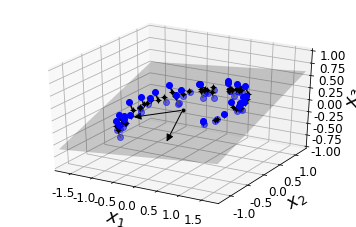

In [61]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=4)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

/Users/sanghyub/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


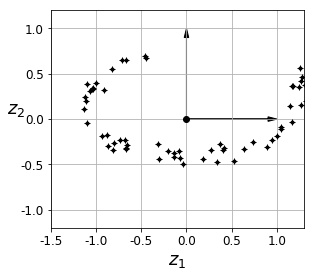

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

## Manifold 학습

In [64]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

/Users/sanghyub/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


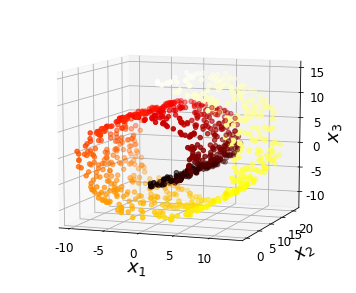

In [68]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c = t, cmap = plt.cm.hot)
ax.view_init(10,-70)
ax.set_xlabel('$x_1$', fontsize = 18, labelpad = 7)
ax.set_ylabel('$x_2$', fontsize = 18, labelpad = 7)
ax.set_zlabel('$x_3$', fontsize = 18)
# ax.set_xlim(axes[0:2])
# ax.set_ylim(axes[2:4])
# ax.set_zlim(axes[4:6])
plt.show()

/Users/sanghyub/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


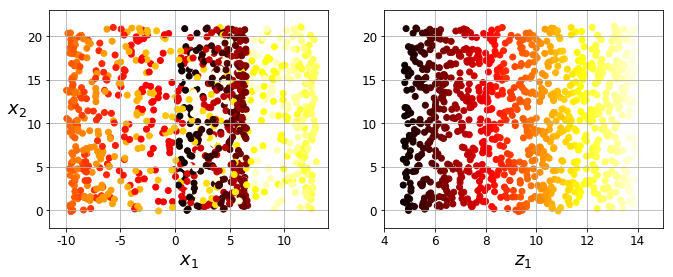

In [70]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0, labelpad=10)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

/Users/sanghyub/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


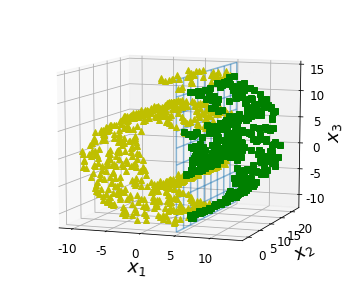

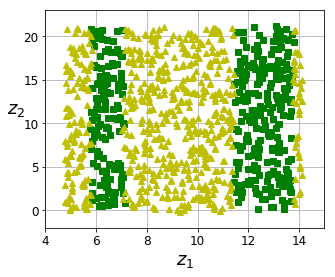

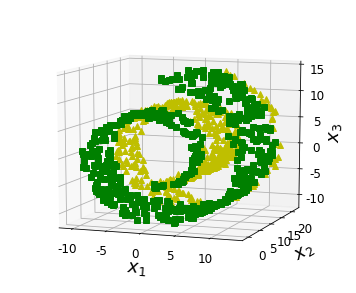

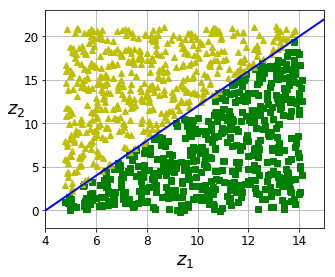

In [77]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0, labelpad=7)
plt.grid(True)


plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0, labelpad=7)
plt.grid(True)


plt.show()

### 연습문제 9

Mnist 로드하고 분할, 랜던 포레스트로 학습시키고 시간 재고, 평가한다.
PCA를 이용해 분산 95%로 차원을 축소, 축소한 데이터셋으로 랜덤 포레스트 훈련시키고
시간 측정, 속도 비교해본다. 평가 결과를 비교해본다.

In [111]:
from keras.datasets import mnist

In [107]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')


In [112]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [113]:
x_train = x_train.reshape(60000, 784)

In [114]:
y_train.shape

(60000,)

In [115]:
x_test = x_test.reshape(10000, 784)

In [116]:
from sklearn.ensemble import RandomForestClassifier

In [117]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)

In [118]:
import time
t0 = time.time()
rnd_clf.fit(x_train,y_train)
t1 = time.time()

In [119]:
print('train time {:.2f}s'.format(t1-t0))

train time 3.92s


In [120]:
from sklearn.metrics import accuracy_score
y_pred = rnd_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.9492

In [121]:
from sklearn.decomposition import PCA

In [122]:
pca = PCA(n_components=0.95)
x_train_reduced = pca.fit_transform(x_train)

In [137]:
rnd_clf2 = RandomForestClassifier(n_estimators=10, random_state=42)
t0 = time.time()
rnd_clf2.fit(x_train_reduced, y_train)
t1 = time.time()

In [138]:
print('train time with pca {:.2f}s'.format(t1-t0))

train time with pca 9.62s


시간이 늘어났다.

In [129]:
x_test.shape

(10000, 784)

In [130]:
x_train.shape

(60000, 784)

In [135]:
x_test_reduced.shape

(10000, 154)

In [139]:
x_test_reduced = pca.transform(x_test)

y_pred = rnd_clf2.predict(x_test_reduced)
accuracy_score(y_test, y_pred)

0.9009

PCA결과, 속도도 느려지고 성능도 안좋아졌다

Softmax회귀에서는 어떨까 결과 확인

In [145]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=2000, random_state=42)
t0 = time.time()
log_clf.fit(x_train, y_train)
t1 = time.time()

/Users/sanghyub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [146]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 436.75s


In [147]:
y_pred = log_clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.9193

In [148]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=2000, random_state=42)
t0 = time.time()
log_clf2.fit(x_train_reduced, y_train)
t1 = time.time()

/Users/sanghyub/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [149]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 123.00s


In [150]:
y_pred = log_clf2.predict(x_test_reduced)
accuracy_score(y_test, y_pred)

0.9236

소프트맥스 회귀의 경우에는 속도도 빠르고 성능도 좋아진 결과를 가져왔다